In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp profile

# Profile

> Set of functions for calculating roughness parameters along profiles 

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

from rough.data import *


In [ ]:
image = np.loadtxt('BYGS008_top_segment_500samp_10cm_interp089.txt')

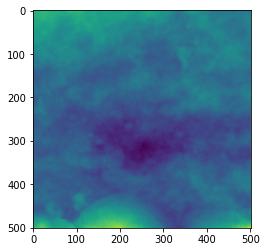

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
#| export
def Ra(im, #Numpy array or arraylike
       axis = 1, #Default to Ra of rows
       norm = True #Normalize the profile by subtracting the mean 
      ):
    '''
    Calculates Mean Absolute Roughness (Ra) along given axis. Defined as the average deviation of absolute height values from the mean line.
    '''
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    return np.mean(np.absolute(im), axis = axis)

In [ ]:
Ra(image)[:5]

array([0.00077332, 0.00076153, 0.00074921, 0.00074354, 0.00073767])

In [ ]:
#| export
def Rms(im, #Numpy array or array like
        axis = 1, #Default to Rms of rows
        norm = True #Normalize the profile by subtracting the mean
       ):
    '''
    Calculates Root Mean Square Roughness (Rms) along given axis. Defined as the root mean square of deviations of height from the mean line of a given profile. 
    '''
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    return np.sqrt(np.mean(np.square(im), axis = axis))

In [ ]:
Rms(image)[:5]

array([0.00092571, 0.00090962, 0.00089242, 0.00087848, 0.00086369])

In [ ]:
#| export
def Rsk(im, #Numpy array or array like
         axis = 1, #Default to Skew of rows
         norm = True, #Normalize the profile by subtracting the mean
        **kwargs #Keyword arguments to modify the skew function
       ):
    '''
    Calcultes the Skew (Rsk) along given axis. Thin wrapper around scipy.stats.skew with bias set to False
    '''
    if norm:
        im = im - np.mean(im, axis=axis, keepdims=True)
    return skew(a = im, axis=axis, **kwargs)

In [ ]:
Rsk(image)[:5]

array([-0.46329922, -0.44371676, -0.42951705, -0.41576231, -0.39316274])

In [ ]:
#| export
def Rku(im, #Numpy array or array like
       axis = 1, #Default to Kurtosis of rows
       norm= True, #Normalize the profile by subtracting the mean
        **kwargs #Keyword arguments to modify the kurtosis function
       ):
    '''
    Calculates the Kurtosis (Rku) along given axis. This wrapper around scipy.stats.kurtosis 
    '''
    if norm:
        im = im - np.mean(im,axis=axis, keepdims=True)
    return kurtosis(a = im, axis = axis, **kwargs)

In [ ]:
Rku(image)[:5]

array([-0.97143403, -1.00073367, -1.03360844, -1.08088846, -1.14600256])

In [ ]:
def peaks(im, #Numpy array or array like
          axis = 1, # Default to peaks of rows
          norm = True, #Normalize the profile by subtracting the mean
          samples = 10, #Number of lengths to divide the profile into
          length = None, #Set measurement length for peak, if set, length_divide and samples are ignored
          mean = False #Return the mean peak height along the axis
         ):
    '''
    Returns the peaks along the axis, either sampled by how many samples (lengths) are requested or by the length of
    each sample. E.g. a 100 pixel profile, if samples = 10, will return 10 results, if length is 20, will return 100/20 
    results.
    '''
    pass

In [ ]:
def not_peaks(im, #Numpy array or array like
          axis = 1, # Default to peaks of rows
          norm = True,
          samples = 10, #Number of lengths to divide the profile into
          length = None, #Set measurement length for peak, if set, length_divide and samples are ignored
         ):
    pass

# Rotational parameters
>
>The following functions return roughness parameters as rotated around the central point of the array.
>Useful for investigating how roughness changes with respect to direction.
>Uses OpenCV/imutils to rotate arrays,because the initial image/array dimensions are preserved 
>by default it gives an easy way to use the diameter of the central circle as the profile. 
>As these are mostly thin wrappers around standard parameters, it is recommended to generate
>an array of rotational profiles using `gen_rot_prof` first and then using standard
>paramaters above. This is highly recommended for very large arrays.

In [ ]:
def rot_Ra(array, axis=1, deg = 180, increment=1):
    '''
    Calculated rotational Ra for a given array
    '''
    return Ra(gen_rot_prof(array,deg=deg,increment=increment), axis = axis)

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()